In [1]:
from scipy.integrate import ode
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
from keras import layers, initializers
from sklearn.preprocessing import MinMaxScaler
from time import time
from os import path

Using plaidml.keras.backend backend.


In [2]:
#from tensorflow.keras.layers import Dense, Dropout
from keras.layers import Dense, Dropout
#Ustvarimo funkcijo, ki vrača kompajlan model
def create_model(activation='sigmoid', optimizer='adam', dropout=0):
    
    model = keras.models.Sequential()
    model.add(Dense(3, input_dim=3, activation=activation))
    model.add(Dense(81, activation=activation))
    if dropout: model.add(Dropout(0.2))
    model.add(Dense(81, activation=activation))
    if dropout: model.add(Dropout(0.2))
    model.add(Dense(81, activation=activation))
    if dropout: model.add(Dropout(0.2))
    model.add(Dense(81, activation=activation))
    if dropout: model.add(Dropout(0.2))
    model.add(Dense(3, activation='sigmoid'))

    model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mae'])

    return model

In [3]:
from sklearn.model_selection import KFold

In [4]:
if(path.exists("data/data-2.npy") != 1):
    print("Generating data.")
    n = int(tmax/dt) + 1
    data = np.zeros((n, 3))

    i = 0
    start = time()
    while t < tmax:
        y_ATM = solver_ATM.integrate(t+dt)
        #y0_MOD = solver_MOD.integrate(t+dt)
        data[i, :] = y_ATM[:]
        i = i + 1
        t += dt
    print("Elasped time: %0.3g s" %(time()-start))
    data = data[1000:] # only use data from the attractor (after time = 10000 * dt)
    print("Integration finished.")
    np.save("data/data-2.npy", data)
    
else:
    print("Data exist.")
    data = np.load("data/data-2.npy")
    print("Data loaded.")
    
#PREPROCESS DATA
x_train = data[:-1,:]
y_train = data[1:, :] - data[:-1, :]

x_scaler=MinMaxScaler()
y_scaler=MinMaxScaler()

x_scaler.fit(x_train)
y_scaler.fit(y_train)

x_train_norm=x_scaler.transform(x_train)
y_train_norm=y_scaler.transform(y_train)

xy_train_norm=np.concatenate((x_train_norm,y_train_norm), axis=1)

new_order=np.random.choice(range(x_train.shape[0]),x_train.shape[0],replace=False)
x_train_norm=x_train_norm[new_order]
y_train_norm=y_train_norm[new_order]

Data exist.
Data loaded.


In [5]:
X = x_train_norm
Y = y_train_norm
len(X)

999000

In [ ]:


num_folds = 3 # dolocimo st. foldov
kf = KFold(n_splits=num_folds, shuffle=True) # razred za razdelitev podatkov

fold_no = 1
scores_per_fold = []
verbose=2
losses = []

# ce nasa Loss ne vec pade se ustavi minimizacija
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=20, verbose=0, mode='min') 
#ce dosezemo plato zmanjsamo korak ucenja
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, min_lr=0.0001)

    
for train, test in kf.split(X[:len(X)], Y[:len(Y)]): #zanka cez vse usne ter testne sete
    modelCV = create_model(dropout=1)
    start=time()
    history = modelCV.fit(X[train], Y[train], epochs=100, batch_size=262144, verbose=verbose,
                          callbacks=[callback,reduce_lr])
    print("Trained in %0.3g" %(time()-start))
    # na fitanem modelu izvrednotimo mere uspesnosti
    # mere uspesnosti bi lahko spremljali ze tekom ucenja, znotraj metode fit
    scores = modelCV.evaluate(X[test], Y[test], verbose=verbose)
    print(f'Score per fold {fold_no}: {modelCV.metrics_names} of {scores}')
    scores_per_fold.append(scores)
    
    losses.append(history.history['loss'])
    fold_no += 1

INFO:plaidml:Opening device "opencl_amd_gfx1010.0"


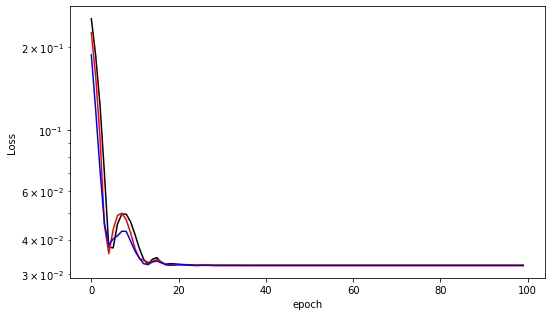

In [8]:
plt.figure(figsize=(7.5, 4.5))
colors=['k','r','b']
for i in range(3):
    plt.plot(losses[i][:], c=colors[i])

plt.xlabel('epoch')
plt.ylabel('Loss')
plt.tight_layout()
#plt.ylim([0, 0.005])
plt.yscale('log')
plt.show()

In [6]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor # Wrapper za Keras model v sklearn

modelGS = KerasRegressor(build_fn=create_model, verbose=2) #ustvarimo model
#veljavni argumenti so argumenti funkcije create_model ter metode fit za Keras model

# najprej dolocimo optimalen batch_size ter stevilo epoh
# uspesnot modela ovrednotimo na vseh kombinacijah parametrov
batch_size = [262144]#, 512] # vrednosti, ki jih preverimo
epochs = [30, 80]
activation=['relu', 'sigmoid']
optimizer = ['SGD', 'adam', 'RMSprop']

# ustvarimo slovar kjer so kljuci imena parametrov
param_grid = dict(optimizer=optimizer, activation=activation, batch_size=batch_size, epochs=epochs)

#ustvarimo objekt z iskanje na mrezi
# specificiramo katero mero uspesnosti gledamo, default je loss funkcija
grid = GridSearchCV(estimator=modelGS, param_grid=param_grid, n_jobs=-1, cv=3, scoring='neg_mean_squared_error', verbose=2)


In [ ]:
grid.fit(X[:len(X)], Y[:len(X)])

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


In [11]:
print("Best: %f using %s" %(grid.best_score_, grid.best_params_))
# pogledamo se rezultate v ostalih tockah
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with : %r' %(mean, stdev, param))

Best: -0.000002 using {'activation': 'relu', 'batch_size': 1024, 'epochs': 100, 'optimizer': 'adam'}
-0.000002 (0.000002) with : {'activation': 'relu', 'batch_size': 1024, 'epochs': 100, 'optimizer': 'adam'}
-0.000011 (0.000003) with : {'activation': 'sigmoid', 'batch_size': 1024, 'epochs': 100, 'optimizer': 'adam'}
